In [1]:
from histograms.histograms import * 

In [2]:
!ls pngs

10.png	12.png	14.png	16.png	18.png	20.png	22.png	24.png	6.png  8.png
11.png	13.png	15.png	17.png	19.png	21.png	23.png	5.png	7.png  9.png


In [3]:
from cv2 import cv2
import numpy as np 

from matplotlib import pyplot as plt 

In [4]:
def draw_pages(page1, page2, title1=None, title2=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 22))
    im = axes[0].imshow(page1, cmap='gray')
    clim=im.properties()['clim']
    axes[1].imshow(page2, cmap='gray', clim=clim)

    plt.subplots_adjust(wspace=0)

    axes[1].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    
    axes[0].set_title(title1)
    axes[1].set_title(title2)

    plt.show()

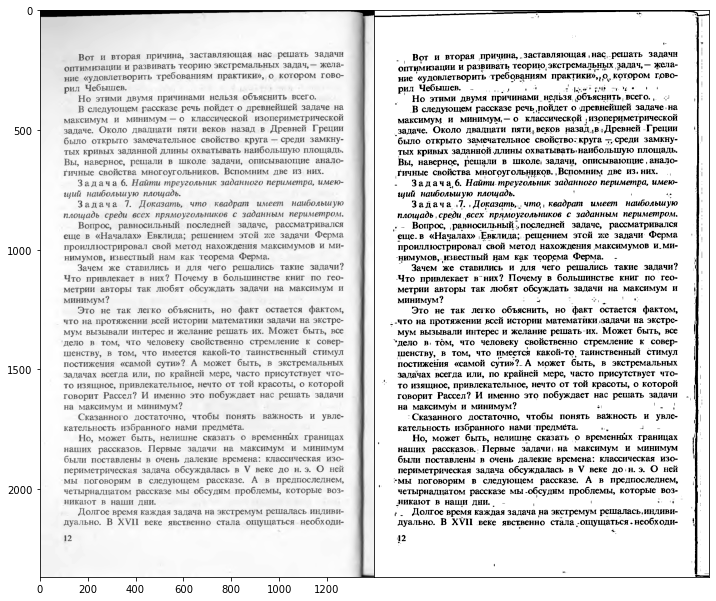

In [5]:
# Читаем картинку из файла, получаем черно-белый вариант
img = cv2.imread('./pngs/12.png', cv2.IMREAD_GRAYSCALE)
imgf = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)


draw_pages(img, imgf)


plt.show()

In [6]:
# Немного повернем страницу, чтобы строки были параллельны краям 
angle = find_best_angle(imgf)
print("{:.4} - angle of rotation: ".format(angle))
rimg = interpolation.rotate(imgf, angle, order=0, cval=255)




-0.303 - angle of rotation: 


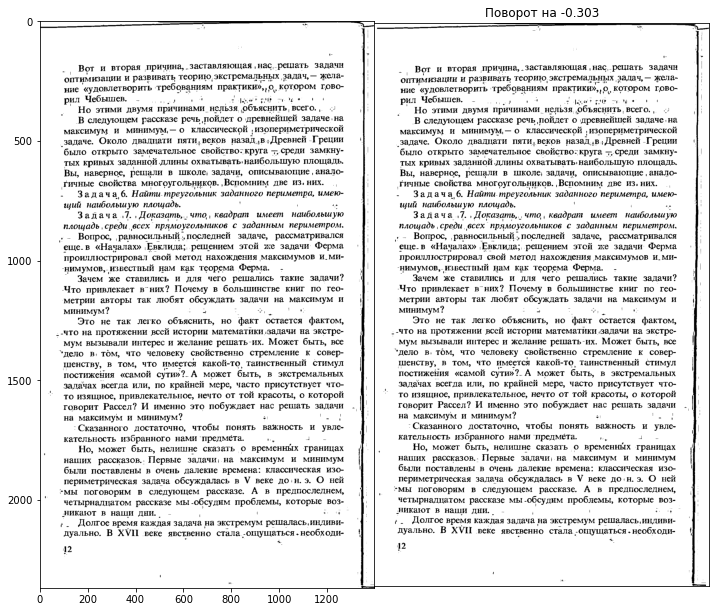

In [7]:
draw_pages(imgf, rimg, None, 'Поворот на {:.4}'.format(angle))

Text(0.5, 1.0, 'Видим, что справа артефакт, который надо удалить\nМетод crop_vertical обрезает картинку ориентируясь по средней линии')

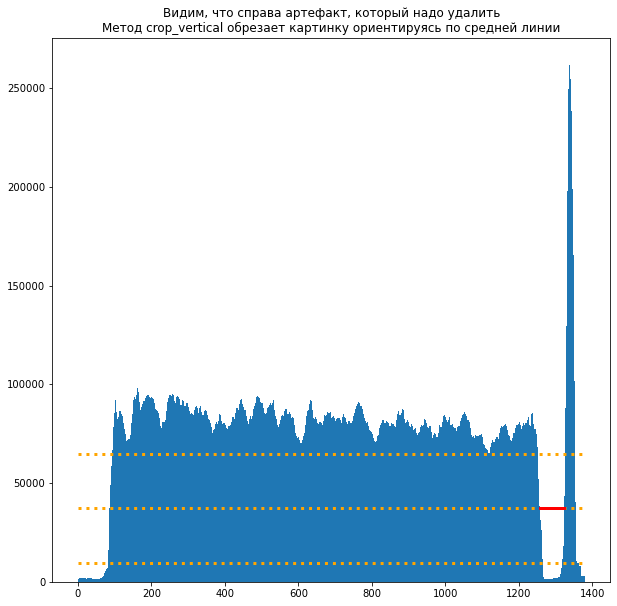

In [8]:
vertical_hist = np.sum(255 - imgf, axis=0)
smoothed = smooth_hist(vertical_hist)
level = find_separate_level(smoothed)

w = len(smoothed)
plt.figure(figsize=(10, 10))
plt.bar(np.arange(w), smoothed, width=1)
plt.plot([0, w], [level, level], color='orange', linestyle=':', linewidth=3)

level = np.mean(level)
surface = smoothed > level 
c, d = find_gulf(surface)
a, b = find_gulf(surface, 0)

plt.plot([0, w], [level, level], linestyle=':', color='orange', linewidth=3)
plt.plot([a, b], [level, level], color='red', linewidth=3)
plt.plot([c, d], [level, level], color='red', linewidth=3)


plt.gca().set_title('Видим, что справа артефакт, который надо удалить\n' + 
                    'Метод crop_vertical обрезает картинку ориентируясь по средней линии')


In [9]:
img_cropped = rimg.copy()
crop_vertical(img_cropped)

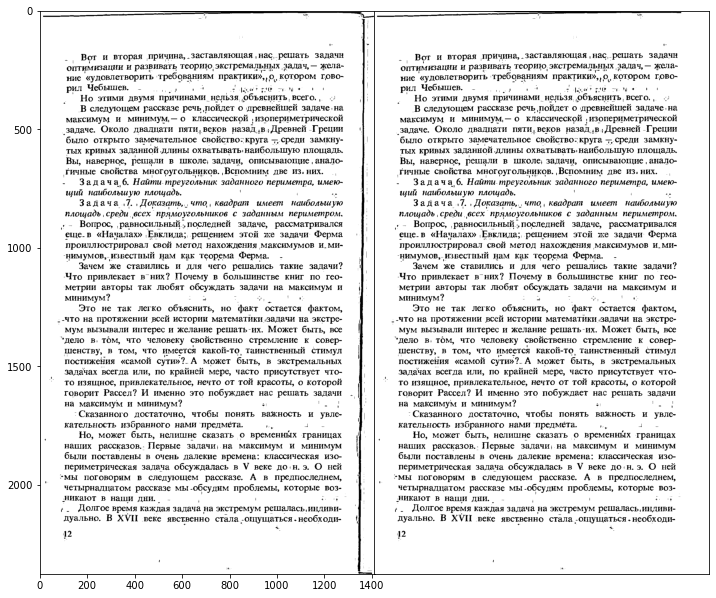

In [10]:
draw_pages(rimg, img_cropped)

Теперь разделим страницу на строки 
=======

array([107431.5 , 105225.75, 105378.75])

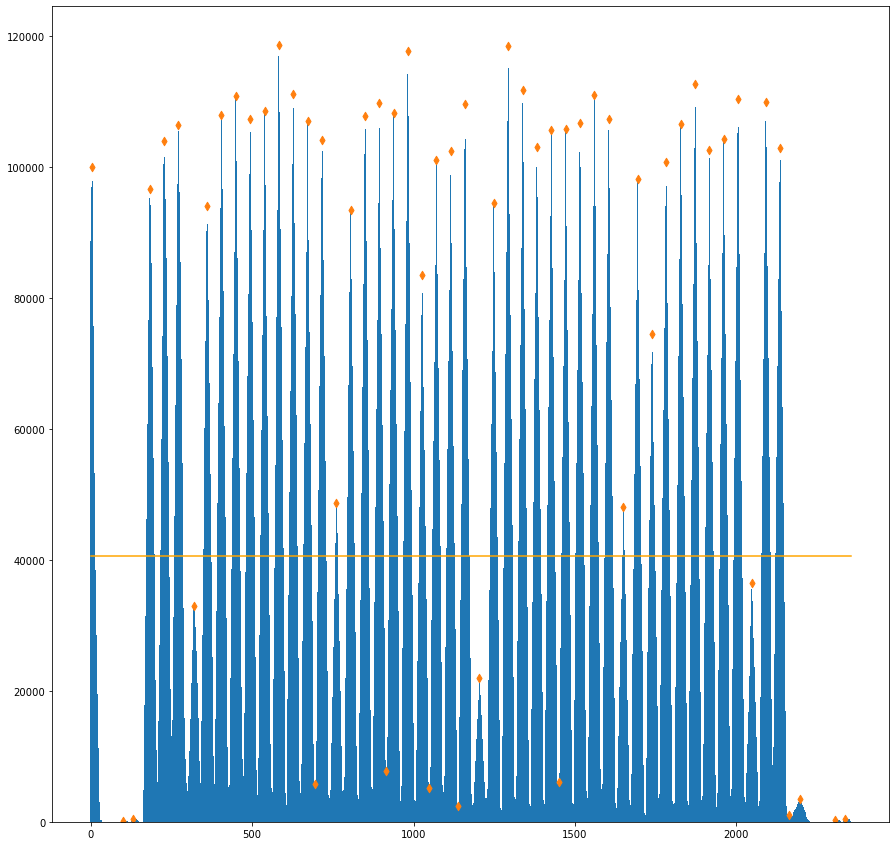

In [11]:
horizontal_hist = np.sum(255 - img_cropped, axis=1)
smoothed = smooth_hist(horizontal_hist)

plt.figure(figsize=(15,15))

mean = np.sum(smoothed) / len(smoothed) 


plt.plot([0, len(smoothed)], [mean, mean], color='orange')
plt.bar(np.arange(len(smoothed)), smoothed, width=1, zorder=0)

loc_max = find_local_maxim(smoothed)   

plt.scatter(loc_max, smoothed[loc_max], marker='d', zorder=1)

smoothed[[loc_max[10], loc_max[10] - 1, loc_max[10] + 1]]

In [12]:
# найдем медианное расстояние между строками 

surface = smoothed > mean
islands = island_lengths(surface)    
lagoons = island_lengths(1 - surface)


avg_dist = np.median(islands) + np.median(lagoons)

In [13]:
lines = []
for i in loc_max:
    a = max(i - int(avg_dist * 3 / 4), 0)
    b = min(i + int(avg_dist * 3 / 4), len(img_cropped))
    lines.append(img_cropped[a:b])
    
    
    
len(lines)  

57

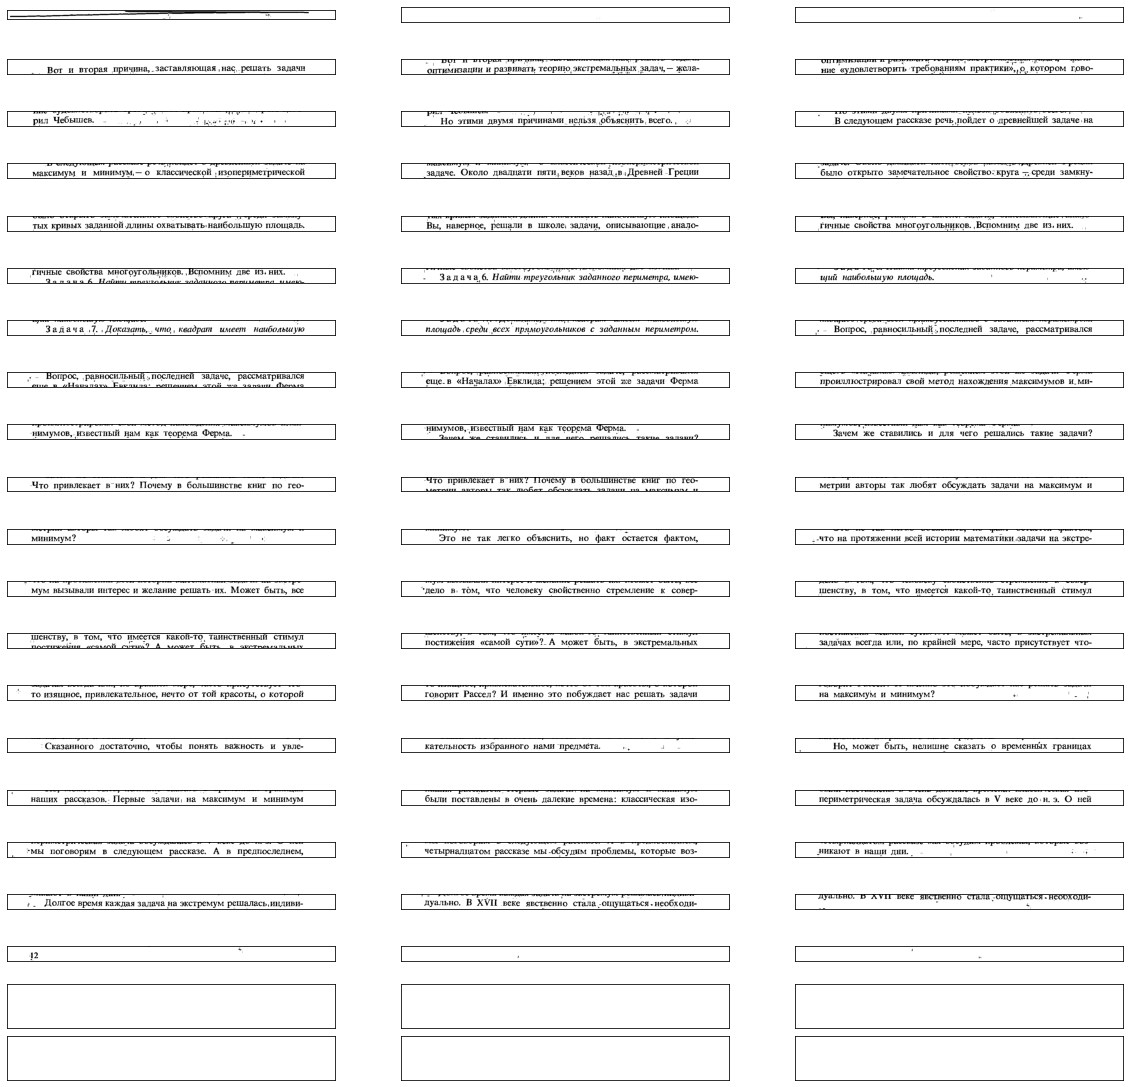

In [14]:
fig, axs = plt.subplots(nrows=21, ncols=3, figsize=(20, 20))


for i in range(63):
    cur_axis = axs[i // 3][i % 3] 
    cur_axis.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    
    if (i < len(lines)):
        cur_axis.imshow(lines[i], cmap='gray')
# надо немного испарвить